# Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation,\
                                    MaxPool2D, UpSampling2D, concatenate,\
                                    Input, Conv2DTranspose, MaxPooling2D,\
                                    Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

import os
import matplotlib.pyplot as plt

# Loss functions and Metrics

In [2]:
class IOU(tf.keras.metrics.Metric):
    def __init__(self, name, C, **kwargs):
        super(IOU, self).__init__(name=name, **kwargs)
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.C = C

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
        value = 0
        for index in range(self.C):
            intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
            union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index]) - intersection
            value += tf.math.reduce_sum((intersection + 1e-16) / (union + 1e-16))
        self.iou.assign_add(value / self.C)

    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))

    def result(self):
        return self.iou

In [3]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name, C, **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1score = self.add_weight(name='f1score', initializer='zeros')
        self.C = C

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
        value = 0
        for index in range(self.C):
            intersection = tf.math.reduce_sum(tf.math.multiply(y_true[..., index], y_pred[..., index]))
            union = tf.math.reduce_sum(y_true[..., index]) + tf.math.reduce_sum(y_pred[..., index])
            value += tf.math.reduce_sum((2. * intersection + 1e-16) / (union + 1e-16))
        self.f1score.assign_add(value / self.C)

    def reset_states(self):
        for s in self.variables:
            s.assign(tf.zeros(shape=s.shape))

    def result(self):
        return self.f1score

In [4]:
class BorderLoss(tf.keras.losses.Loss):
    """
    https://arxiv.org/pdf/1812.07032.pdf
    https://github.com/LIVIAETS/boundary-loss/blob/master/keras_loss.py
    """
    def __init__(self, C : "Num of classes, third dimenstion", 
               name="border_loss_function", reduction=tf.keras.losses.Reduction.NONE):
        super().__init__(reduction=reduction, name=name)
        self.C = C

    def calc_dist_map(self, seg):
        res = np.zeros_like(seg)
        posmask = seg.astype(np.bool)

        if posmask.any():
            negmask = ~posmask
            res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

        return res

    def calc_dist_map_batch(self, y_true):
        y_true_numpy = y_true.numpy()
        return np.array([self.calc_dist_map(y)
                      for y in y_true_numpy]).astype(np.float32)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)

        result_list = []
        for index in range(self.C):
            y_true_dist_map = self.calc_dist_map_batch(y_true[..., index])
            result = y_pred[..., index] * y_true_dist_map
            result_list.append(result)
        return tf.stack(result)

In [5]:
class HybridLoss(tf.keras.losses.Loss):
    def __init__(self, _lambda_, _alpha, _beta, smooth=1e-16, C=3, weights=[0.5, 2.0, 0.5], 
               reduction=tf.keras.losses.Reduction.NONE,
               name='tversky_loss_function'):
        super().__init__(reduction=reduction, name=name)
        self._lambda_ = _lambda_
        self._alpha = _alpha
        self._beta = _beta
        self.smooth = smooth
        self.C = C
        self.weights = weights

    def tversky_loss(self, y_true, y_pred):
        y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
        tversky = []
        for index in range(self.C): # Class order: Forest, Deforest., Other.

            TP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)
            FP = tf.reduce_sum(tf.math.multiply(y_pred[..., index], 1-y_true[..., index]), axis=1)
            FN = tf.reduce_sum(tf.math.multiply(1-y_pred[..., index], y_true[..., index]), axis=1)

            tversky_i = (TP + self.smooth) / (TP + self._alpha * FP + self._beta * FN + self.smooth)  
            tversky.append(tversky_i * self.weights[index])
        return self.C - tf.stack(tversky)

    def dice_coef_multilabel(self, y_true, y_pred):
        y_true = tf.reshape(y_true, (tf.shape(y_true)[0], -1, tf.shape(y_true)[-1]))
        y_pred = tf.reshape(y_pred, (tf.shape(y_pred)[0], -1, tf.shape(y_pred)[-1]))
        dice = []
        for index in range(self.C):
            intersection = 2 * tf.reduce_sum(tf.math.multiply(y_pred[..., index], y_true[..., index]), axis=1)+ self.smooth
            denominator = tf.reduce_sum(tf.math.square(y_pred[..., index]) + tf.math.square(y_true[..., index]), axis=1)+ self.smooth
            dice_i = intersection / denominator 
            dice.append(- dice_i)
        return self.C + tf.stack(dice)

    def call(self, y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)

        tversky = self.tversky_loss(y_true, y_pred)
        dice = self.dice_coef_multilabel(y_true, y_pred)   
        result = tversky + self._lambda_ * dice
        #result = tf.reduce_sum(result)
        return result

# Dataset loading

In [6]:
# Adjust these constants as needed
IMAGE_SIZE = [512, 512]
BATCH_SIZE = 1
SHUFFLE_BUFFER_SIZE = 2048

def load_image_and_mask(image_path):
    # Read and decode the image
    image_content = tf.io.read_file(image_path)
    image = tf.io.decode_png(image_content, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0

    # Construct the corresponding mask path
    # Assuming mask filename matches the image filename and
    # is located in the 'masks' directory instead of 'images'
    mask_path = tf.strings.regex_replace(image_path, "images", "masks")
    mask_content = tf.io.read_file(mask_path)
    mask = tf.io.decode_png(mask_content, channels=3)
    mask = tf.image.resize(mask, IMAGE_SIZE)
    mask = tf.cast(mask, tf.float32) / 255.0

    return image, mask

def get_dataset(images_dir, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    # Get a list of all image filenames
    image_files = tf.data.Dataset.list_files(os.path.join(images_dir, '*.png'), shuffle=True)

    # Map each image file to (image, mask) pair
    dataset = image_files.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle, batch, and prefetch for performance
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    # dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [7]:
def show_batch(dataset, num_examples=4):
    # Get one batch of images and masks
    image_batch, mask_batch = next(iter(dataset))
    
    # Convert to numpy arrays for plotting
    images = image_batch.numpy()
    masks = mask_batch.numpy()
    
    # Create a figure with num_examples rows and 2 columns:
    # left column for the image, right column for the mask
    fig, axes = plt.subplots(num_examples, 2, figsize=(10, 5 * num_examples))
    
    for i in range(num_examples):
        # If there's only one example, axes won't be a list of lists
        if num_examples == 1:
            ax_img, ax_mask = axes
        else:
            ax_img, ax_mask = axes[i]

        # Plot the image
        ax_img.imshow(images[i])
        ax_img.set_title("Image")
        ax_img.axis("off")
        
        # Plot the corresponding mask
        # If your mask is a binary or single-channel mask, you may need to adjust how it is displayed.
        # Here we assume 3-channel masks for visualization.
        ax_mask.imshow(masks[i])
        ax_mask.set_title("Mask")
        ax_mask.axis("off")
    
    plt.tight_layout()
    plt.show()

In [8]:
images_dir = "Dataset/data_shaffled_8_04_2021-20241207T162054Z-001/data_shaffled_8_04_2021/images"

train_dataset = get_dataset(images_dir, batch_size=BATCH_SIZE)

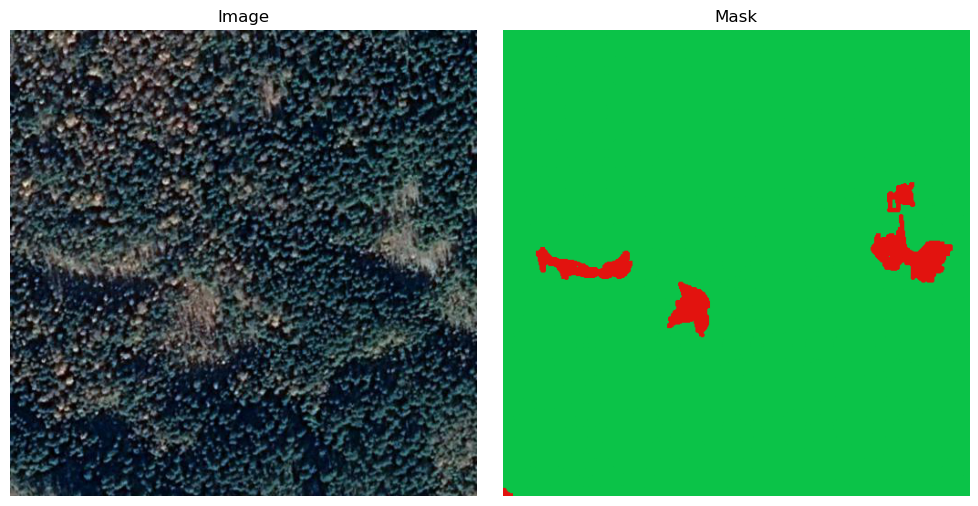

In [9]:
show_batch(train_dataset, num_examples=1)

# Model building

In [10]:
def make_unet_experimental():
    input_size = (512, 512,3)
    inputs = Input(input_size)

    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    up2_1  = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    up3_1  = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv3))
    up3_2  = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up3_1))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    up4_1  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv4))
    up4_2  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_1))
    up4_3  = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up4_2))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    up5_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv5))
    up5_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_1))
    up5_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_2))
    up5_4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(up5_3))

    up6 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv4, up6, up5_1], axis = 3)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3, up7, up5_2, up4_1], axis = 3)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2, up8, up5_3, up4_2, up3_1], axis = 3)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1, up9, up5_4, up4_3, up3_2, up2_1], axis = 3)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = Conv2D(3, 1, activation = 'softmax')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [11]:
model = make_unet_experimental()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 256, 256, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
# Compile the model
loss_object = HybridLoss(_lambda_=1, _alpha=0.5, _beta=0.5, weights=[0.4, 2.2, 0.4], reduction=tf.keras.losses.Reduction.NONE)

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    # loss=CategoricalCrossentropy(),
    loss=loss_object,
    metrics=['accuracy']  # Add IoU or F1 if implemented as tf.keras.metrics
)

In [13]:
# Set up directory for checkpoints and logs
model_name = "unet_experimental_model"
checkpoint_dir = f"./checkpoints/{model_name}/"
csv_log_file = f"./logs/{model_name}.csv"

tf.io.gfile.makedirs(checkpoint_dir)

# Callbacks

In [14]:
class PlotPredictionsCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_dataset, output_dir="./epoch_predictions", num_examples=3):
        super().__init__()
        self.val_dataset = val_dataset
        self.output_dir = output_dir
        self.num_examples = num_examples

        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

        # Pre-fetch a batch to keep consistent examples each epoch (optional)
        self.sample_batch = next(iter(self.val_dataset))
    
    def on_epoch_end(self, epoch, logs=None):
        images, true_masks = self.sample_batch
        pred_masks = self.model.predict(images, verbose=0)

        # Select the first `num_examples` samples to visualize
        for i in range(self.num_examples):
            image = images[i].numpy()
            true_mask = true_masks[i].numpy()
            pred_mask = pred_masks[i]

            # Create a figure with 1 row and 3 columns: Image | True Mask | Predicted Mask
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Show the input image
            axes[0].imshow(image)
            axes[0].set_title("Input Image")
            axes[0].axis("off")

            # Show the ground truth mask
            # If mask is multi-channel, you may visualize one channel or decode as needed
            axes[1].imshow(true_mask)
            axes[1].set_title("True Mask")
            axes[1].axis("off")

            # Show the predicted mask
            # If the mask is softmax output across multiple classes, you might choose the argmax:
            # pred_mask_argmax = np.argmax(pred_mask, axis=-1)
            # axes[2].imshow(pred_mask_argmax, cmap='gray')
            # Otherwise, if it's already 3-channel, just show it directly:
            axes[2].imshow(pred_mask)
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.tight_layout()
            # Save figure
            fig_path = os.path.join(self.output_dir, f"epoch_{epoch+1}_example_{i+1}.png")
            plt.savefig(fig_path)
            plt.close(fig)

In [15]:
# Assuming `val_dataset` and `model.fit()` call is already defined
plot_callback = PlotPredictionsCallback(train_dataset, output_dir="./epoch_predictions", num_examples=1)

# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_dir + "epoch_{epoch:02d}-val_accuracy_{val_accuracy:.4f}.h5", 
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

csv_logger = CSVLogger(csv_log_file, append=True)

# Training

In [16]:
# Train the model
EPOCHS = 5
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    # validation_data=val_dataset,
    callbacks=[plot_callback]
)

Epoch 1/5
322/322 [==============================] - 164s 356ms/step - loss: 4.9253 - accuracy: 0.1162
Epoch 2/5
322/322 [==============================] - 117s 361ms/step - loss: 4.9029 - accuracy: 0.1100
Epoch 3/5
322/322 [==============================] - 117s 361ms/step - loss: 4.8645 - accuracy: 0.1005
Epoch 4/5
322/322 [==============================] - 117s 362ms/step - loss: 4.8426 - accuracy: 0.1048
Epoch 5/5
322/322 [==============================] - 117s 362ms/step - loss: 4.8271 - accuracy: 0.1179
